In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
#ADD SUPPORT POINTS!

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [80]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")
    
    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')
    
def prepare_data(paper):
        
    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst') 

        df.columns = [str(c).replace('<','') for c in df.columns]
        df.columns = [str(c).replace('>','') for c in df.columns]

        df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()
    
    return df

def prepare_index(indeks):
    
    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')
       
    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst') 

        df.columns = [str(c).replace('<','') for c in df.columns]
        df.columns = [str(c).replace('>','') for c in df.columns]

        df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()
    
    return df

In [39]:
update_indexes()

Updated 2020-04-11, max actual date:     2020-04-10


In [40]:
update_stocks()

Updated 2020-04-11, max actual date:     2020-04-09


In [15]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}')

no of all available stock: 1957 and indexes: 23


## Single plot

In [43]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [47]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [48]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [50]:
[a for a in all_stocks if 'MOB' in a]

['IMMOBILE.mst']

In [51]:
papier = 'NEUCA'

In [52]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/showletter/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


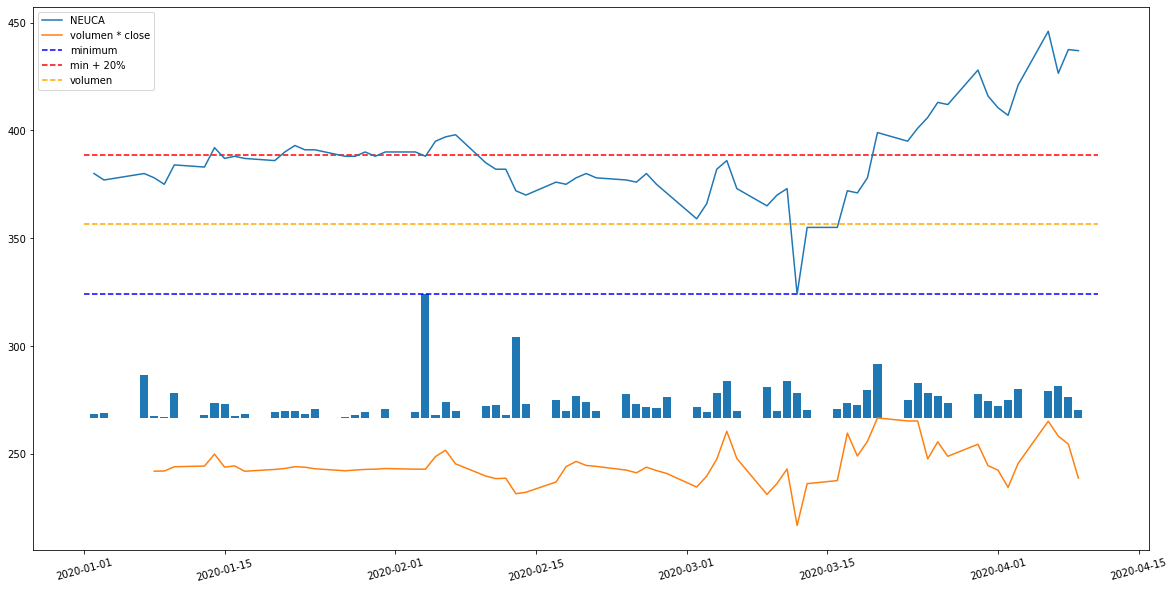

In [53]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [54]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [55]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: NEUCA, currently at 437.0, with potential -8.92% to top
Max before crisis: 398.0
Crisis bottom: 324.0
Max after crisis drop: 446.0, at 2020-04-06 00:00:00
Stats after Max: [446.  426.5 437.5 437. ]


## Skaner

In [56]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [93]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:05<00:00, 362.91it/s]


In [94]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [95]:
skaner_df_see = skaner_df.loc[
#     (skaner_df.growth_quarter > 0) 
#         & (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        (skaner_df.growth_current > 20)
                              ,:].sort_values('drop_current', ascending=True)

In [96]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [97]:
skaner_df_see.shape

(202, 14)

In [98]:
skaner_df_see.tail(100)

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,VOTUM,11.000,14.100,11.4000,8.1800,8.200,11.250,14.950,23.68,39.36,37.20,34.15,35.91,-26.42
0,FERRO,13.500,17.250,13.7000,13.9000,10.300,13.500,18.250,25.91,-1.44,31.07,31.07,35.19,-26.03
0,DIGITREE,4.440,4.900,NaN,NaN,3.400,4.480,6.000,NaN,NaN,31.76,30.59,35.14,-26.00
0,RADPOL,1.170,1.455,1.1400,1.4150,0.940,1.180,1.580,27.63,-19.43,25.53,24.47,35.04,-25.95
0,WIRTUALNA,64.000,84.600,66.8000,58.0000,47.400,64.000,86.400,26.65,15.17,35.02,35.02,35.00,-25.93
0,DECORA,14.900,19.700,17.5000,18.1000,11.900,16.000,20.000,12.57,-3.31,34.45,25.21,34.23,-25.50
0,ADIUVO,5.740,6.300,7.3000,8.2600,4.700,7.260,7.700,-13.70,-11.62,54.47,22.13,34.15,-25.45
0,TORPOL,6.640,8.900,6.8800,6.9600,5.000,6.900,8.900,29.36,-1.15,38.00,32.80,34.04,-25.39
0,POLICE,10.600,10.500,NaN,14.5000,7.100,10.600,14.200,NaN,NaN,49.30,49.30,33.96,-25.35
0,VIVID,1.312,1.714,1.3000,1.4400,0.980,1.438,1.750,31.85,-9.72,46.73,33.88,33.38,-25.03


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

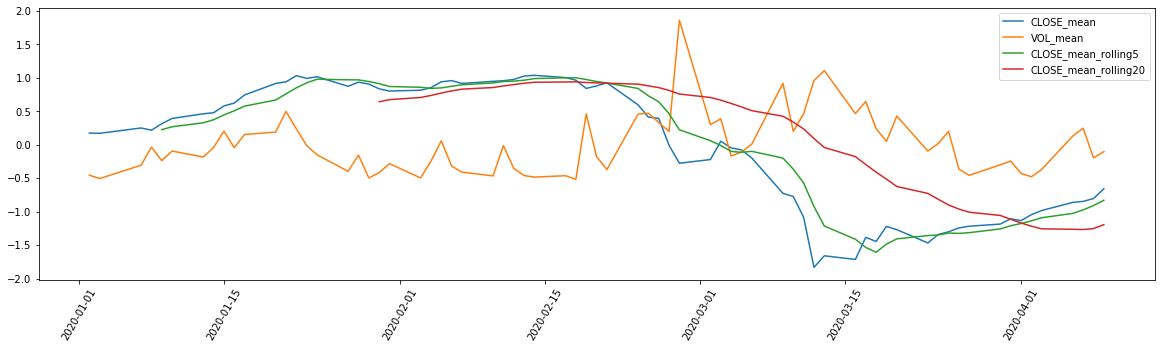

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [99]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [55]:
def transform_one_paper(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    #df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    df.loc[:, 'target'] = np.nan
    df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
    df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    return df

In [388]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'chng_OPEN1_CLOSE'] = (df.loc[:,'OPEN'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'chng_LOW1_CLOSE'] = (df.loc[:,'LOW'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'chng_HIGH1_CLOSE'] = (df.loc[:,'HIGH'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
       
#     df.loc[df.loc[:, 'LOW'] > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER'] = 1
#     df.loc[df.loc[:, 'LOW'] <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER'] = 0
    
#     df.loc[df.loc[:, 'LOW'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 0
    
#     df.loc[df.loc[:, 'HIGH'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 0
    
#     df.loc[df.loc[:, 'OPEN'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 0
      
#     df.loc[df.loc[:, 'CLOSE'] > df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 1
#     df.loc[df.loc[:, 'CLOSE'] <= df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 0
    
#     df.loc[:,'same_CLOSE_LOW'] = 0
#     df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'LOW'],'same_CLOSE_LOW'] = 1
#     df.loc[:,'same_CLOSE_HIGH'] = 0
#     df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'HIGH'],'same_CLOSE_HIGH'] = 1
    
#     df.loc[:,'same_OPEN_LOW'] = 0
#     df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'LOW'],'same_OPEN_LOW'] = 1
#     df.loc[:,'same_OPEN_HIGH'] = 0
#     df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'HIGH'],'same_OPEN_HIGH'] = 1
    
    
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
    #historic features

#     for a in [c for c in df.columns if ('chng_' in c) | ('move_' in c) | ('comp_' in c)]:
#         for i in [1, 2, 3, 4, 5]:
#             df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('comp_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()

### TARGET SECTION ###

#     df.loc[:, 'target'] = df.loc[:, 'chng_rel_OPEN'].shift(-1)
#    df.loc[:,'target'] = df.loc[:,'comp_CLOSE_OPEN'].shift(-1)
    df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0
    
#df.loc[:, 'target'] = df.loc[:,'diff_LOW_HIGH'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0

#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'], 'target'] = 0
    
#     df.loc[:, 'target'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target'] = df.loc[:, 'chng_OPEN'].shift(-1)
#     df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    return df

In [389]:
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [390]:
df_merged = pd.DataFrame()

for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 202/202 [03:22<00:00,  1.00s/it]


In [391]:
df_merged_copy = df_merged.copy()

In [392]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
        
    df = transform_one_index(df) 
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 45.41it/s]


In [393]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

In [394]:
df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [395]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c)]

In [396]:
train_cols = train_cols + list(df_indexes_merged.columns)

In [397]:
#train_cols = train_cols_limited

df = df_merged.copy()

cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [398]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')

# # # Initialize CatBoostRegressor
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [399]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.6767058	test: 0.6937354	best: 0.6937354 (0)	total: 12.9ms	remaining: 2m 8s
1:	learn: 0.6812139	test: 0.6972643	best: 0.6972643 (1)	total: 24.8ms	remaining: 2m 3s
2:	learn: 0.6820519	test: 0.7001382	best: 0.7001382 (2)	total: 36.8ms	remaining: 2m 2s
3:	learn: 0.6836522	test: 0.7011286	best: 0.7011286 (3)	total: 48.7ms	remaining: 2m 1s
4:	learn: 0.6887096	test: 0.7069435	best: 0.7069435 (4)	total: 60.6ms	remaining: 2m 1s
5:	learn: 0.6897548	test: 0.7077050	best: 0.7077050 (5)	total: 73.2ms	remaining: 2m 1s
6:	learn: 0.6917226	test: 0.7098564	best: 0.7098564 (6)	total: 87.1ms	remaining: 2m 4s
7:	learn: 0.6943013	test: 0.7129375	best: 0.7129375 (7)	total: 104ms	remaining: 2m 10s
8:	learn: 0.6968449	test: 0.7154922	best: 0.7154922 (8)	total: 117ms	remaining: 2m 9s
9:	learn: 0.6982644	test: 0.7183388	best: 0.7183388 (9)	total: 128ms	remaining: 2m 8s
10:	learn: 0.6991091	test: 0.7187412	best: 0.7187412 (10)	total: 142ms	remaining: 2m 8s
11:	learn: 0.6994772	test: 0.7191071	best: 0

104:	learn: 0.7219479	test: 0.7407309	best: 0.7407309 (104)	total: 1.23s	remaining: 1m 56s
105:	learn: 0.7220601	test: 0.7408123	best: 0.7408123 (105)	total: 1.24s	remaining: 1m 56s
106:	learn: 0.7221497	test: 0.7412032	best: 0.7412032 (106)	total: 1.25s	remaining: 1m 55s
107:	learn: 0.7222481	test: 0.7412721	best: 0.7412721 (107)	total: 1.26s	remaining: 1m 55s
108:	learn: 0.7223340	test: 0.7414183	best: 0.7414183 (108)	total: 1.28s	remaining: 1m 56s
109:	learn: 0.7224121	test: 0.7417917	best: 0.7417917 (109)	total: 1.29s	remaining: 1m 55s
110:	learn: 0.7224982	test: 0.7421799	best: 0.7421799 (110)	total: 1.3s	remaining: 1m 55s
111:	learn: 0.7226306	test: 0.7422017	best: 0.7422017 (111)	total: 1.31s	remaining: 1m 55s
112:	learn: 0.7226909	test: 0.7422517	best: 0.7422517 (112)	total: 1.32s	remaining: 1m 55s
113:	learn: 0.7228046	test: 0.7423011	best: 0.7423011 (113)	total: 1.33s	remaining: 1m 55s
114:	learn: 0.7228634	test: 0.7423801	best: 0.7423801 (114)	total: 1.34s	remaining: 1m 55s


197:	learn: 0.7284129	test: 0.7486058	best: 0.7486058 (197)	total: 2.24s	remaining: 1m 50s
198:	learn: 0.7284674	test: 0.7487057	best: 0.7487057 (198)	total: 2.25s	remaining: 1m 50s
199:	learn: 0.7285078	test: 0.7487841	best: 0.7487841 (199)	total: 2.26s	remaining: 1m 50s
200:	learn: 0.7285693	test: 0.7488139	best: 0.7488139 (200)	total: 2.27s	remaining: 1m 50s
201:	learn: 0.7286190	test: 0.7488680	best: 0.7488680 (201)	total: 2.28s	remaining: 1m 50s
202:	learn: 0.7286727	test: 0.7489157	best: 0.7489157 (202)	total: 2.29s	remaining: 1m 50s
203:	learn: 0.7286962	test: 0.7489209	best: 0.7489209 (203)	total: 2.3s	remaining: 1m 50s
204:	learn: 0.7287558	test: 0.7490136	best: 0.7490136 (204)	total: 2.31s	remaining: 1m 50s
205:	learn: 0.7287962	test: 0.7490336	best: 0.7490336 (205)	total: 2.33s	remaining: 1m 50s
206:	learn: 0.7288321	test: 0.7491933	best: 0.7491933 (206)	total: 2.34s	remaining: 1m 50s
207:	learn: 0.7288681	test: 0.7492323	best: 0.7492323 (207)	total: 2.35s	remaining: 1m 50s


292:	learn: 0.7317633	test: 0.7528426	best: 0.7528512 (291)	total: 3.27s	remaining: 1m 48s
293:	learn: 0.7317944	test: 0.7529305	best: 0.7529305 (293)	total: 3.28s	remaining: 1m 48s
294:	learn: 0.7318129	test: 0.7529596	best: 0.7529596 (294)	total: 3.29s	remaining: 1m 48s
295:	learn: 0.7318406	test: 0.7529589	best: 0.7529596 (294)	total: 3.3s	remaining: 1m 48s
296:	learn: 0.7318668	test: 0.7529562	best: 0.7529596 (294)	total: 3.31s	remaining: 1m 48s
297:	learn: 0.7318865	test: 0.7529718	best: 0.7529718 (297)	total: 3.32s	remaining: 1m 48s
298:	learn: 0.7319123	test: 0.7531501	best: 0.7531501 (298)	total: 3.33s	remaining: 1m 48s
299:	learn: 0.7319343	test: 0.7531834	best: 0.7531834 (299)	total: 3.35s	remaining: 1m 48s
300:	learn: 0.7319672	test: 0.7532052	best: 0.7532052 (300)	total: 3.36s	remaining: 1m 48s
301:	learn: 0.7319933	test: 0.7532213	best: 0.7532213 (301)	total: 3.37s	remaining: 1m 48s
302:	learn: 0.7320250	test: 0.7532635	best: 0.7532635 (302)	total: 3.38s	remaining: 1m 48s


393:	learn: 0.7340147	test: 0.7561669	best: 0.7562203 (392)	total: 4.49s	remaining: 1m 49s
394:	learn: 0.7340371	test: 0.7561824	best: 0.7562203 (392)	total: 4.5s	remaining: 1m 49s
395:	learn: 0.7340553	test: 0.7561860	best: 0.7562203 (392)	total: 4.52s	remaining: 1m 49s
396:	learn: 0.7340810	test: 0.7562120	best: 0.7562203 (392)	total: 4.53s	remaining: 1m 49s
397:	learn: 0.7340935	test: 0.7562265	best: 0.7562265 (397)	total: 4.54s	remaining: 1m 49s
398:	learn: 0.7341082	test: 0.7562227	best: 0.7562265 (397)	total: 4.55s	remaining: 1m 49s
399:	learn: 0.7341214	test: 0.7562355	best: 0.7562355 (399)	total: 4.56s	remaining: 1m 49s
400:	learn: 0.7341482	test: 0.7562474	best: 0.7562474 (400)	total: 4.57s	remaining: 1m 49s
401:	learn: 0.7341709	test: 0.7563006	best: 0.7563006 (401)	total: 4.58s	remaining: 1m 49s
402:	learn: 0.7341819	test: 0.7563236	best: 0.7563236 (402)	total: 4.59s	remaining: 1m 49s
403:	learn: 0.7342030	test: 0.7563810	best: 0.7563810 (403)	total: 4.6s	remaining: 1m 49s
4

484:	learn: 0.7356352	test: 0.7582860	best: 0.7582860 (484)	total: 5.5s	remaining: 1m 47s
485:	learn: 0.7356486	test: 0.7582836	best: 0.7582860 (484)	total: 5.51s	remaining: 1m 47s
486:	learn: 0.7356688	test: 0.7583158	best: 0.7583158 (486)	total: 5.52s	remaining: 1m 47s
487:	learn: 0.7356815	test: 0.7583275	best: 0.7583275 (487)	total: 5.53s	remaining: 1m 47s
488:	learn: 0.7356983	test: 0.7583013	best: 0.7583275 (487)	total: 5.54s	remaining: 1m 47s
489:	learn: 0.7357189	test: 0.7582978	best: 0.7583275 (487)	total: 5.55s	remaining: 1m 47s
490:	learn: 0.7357312	test: 0.7583135	best: 0.7583275 (487)	total: 5.56s	remaining: 1m 47s
491:	learn: 0.7357396	test: 0.7583288	best: 0.7583288 (491)	total: 5.57s	remaining: 1m 47s
492:	learn: 0.7357566	test: 0.7583404	best: 0.7583404 (492)	total: 5.59s	remaining: 1m 47s
493:	learn: 0.7357672	test: 0.7583354	best: 0.7583404 (492)	total: 5.6s	remaining: 1m 47s
494:	learn: 0.7357804	test: 0.7583583	best: 0.7583583 (494)	total: 5.61s	remaining: 1m 47s
4

581:	learn: 0.7369323	test: 0.7596281	best: 0.7596281 (581)	total: 6.52s	remaining: 1m 45s
582:	learn: 0.7369446	test: 0.7596355	best: 0.7596355 (582)	total: 6.53s	remaining: 1m 45s
583:	learn: 0.7369652	test: 0.7596626	best: 0.7596626 (583)	total: 6.54s	remaining: 1m 45s
584:	learn: 0.7369766	test: 0.7596667	best: 0.7596667 (584)	total: 6.56s	remaining: 1m 45s
585:	learn: 0.7369847	test: 0.7596624	best: 0.7596667 (584)	total: 6.57s	remaining: 1m 45s
586:	learn: 0.7369948	test: 0.7596582	best: 0.7596667 (584)	total: 6.58s	remaining: 1m 45s
587:	learn: 0.7370024	test: 0.7596654	best: 0.7596667 (584)	total: 6.59s	remaining: 1m 45s
588:	learn: 0.7370195	test: 0.7596673	best: 0.7596673 (588)	total: 6.6s	remaining: 1m 45s
589:	learn: 0.7370404	test: 0.7597031	best: 0.7597031 (589)	total: 6.61s	remaining: 1m 45s
590:	learn: 0.7370524	test: 0.7597184	best: 0.7597184 (590)	total: 6.62s	remaining: 1m 45s
591:	learn: 0.7370651	test: 0.7597477	best: 0.7597477 (591)	total: 6.63s	remaining: 1m 45s


676:	learn: 0.7380065	test: 0.7606268	best: 0.7606268 (676)	total: 7.54s	remaining: 1m 43s
677:	learn: 0.7380175	test: 0.7606159	best: 0.7606268 (676)	total: 7.55s	remaining: 1m 43s
678:	learn: 0.7380270	test: 0.7606314	best: 0.7606314 (678)	total: 7.56s	remaining: 1m 43s
679:	learn: 0.7380381	test: 0.7607648	best: 0.7607648 (679)	total: 7.57s	remaining: 1m 43s
680:	learn: 0.7380443	test: 0.7608138	best: 0.7608138 (680)	total: 7.58s	remaining: 1m 43s
681:	learn: 0.7380505	test: 0.7608027	best: 0.7608138 (680)	total: 7.59s	remaining: 1m 43s
682:	learn: 0.7380620	test: 0.7608036	best: 0.7608138 (680)	total: 7.6s	remaining: 1m 43s
683:	learn: 0.7380717	test: 0.7607996	best: 0.7608138 (680)	total: 7.61s	remaining: 1m 43s
684:	learn: 0.7380792	test: 0.7608302	best: 0.7608302 (684)	total: 7.62s	remaining: 1m 43s
685:	learn: 0.7380872	test: 0.7608371	best: 0.7608371 (685)	total: 7.64s	remaining: 1m 43s
686:	learn: 0.7380987	test: 0.7608494	best: 0.7608494 (686)	total: 7.65s	remaining: 1m 43s


771:	learn: 0.7388973	test: 0.7614776	best: 0.7614776 (771)	total: 8.55s	remaining: 1m 42s
772:	learn: 0.7389143	test: 0.7614907	best: 0.7614907 (772)	total: 8.56s	remaining: 1m 42s
773:	learn: 0.7389280	test: 0.7615071	best: 0.7615071 (773)	total: 8.57s	remaining: 1m 42s
774:	learn: 0.7389324	test: 0.7614986	best: 0.7615071 (773)	total: 8.58s	remaining: 1m 42s
775:	learn: 0.7389365	test: 0.7615015	best: 0.7615071 (773)	total: 8.59s	remaining: 1m 42s
776:	learn: 0.7389413	test: 0.7615028	best: 0.7615071 (773)	total: 8.6s	remaining: 1m 42s
777:	learn: 0.7389462	test: 0.7614947	best: 0.7615071 (773)	total: 8.61s	remaining: 1m 42s
778:	learn: 0.7389504	test: 0.7614994	best: 0.7615071 (773)	total: 8.62s	remaining: 1m 42s
779:	learn: 0.7389603	test: 0.7615063	best: 0.7615071 (773)	total: 8.63s	remaining: 1m 42s
780:	learn: 0.7389702	test: 0.7614987	best: 0.7615071 (773)	total: 8.64s	remaining: 1m 42s
781:	learn: 0.7389804	test: 0.7614976	best: 0.7615071 (773)	total: 8.65s	remaining: 1m 41s


869:	learn: 0.7397263	test: 0.7623704	best: 0.7623704 (869)	total: 9.58s	remaining: 1m 40s
870:	learn: 0.7397447	test: 0.7623841	best: 0.7623841 (870)	total: 9.59s	remaining: 1m 40s
871:	learn: 0.7397494	test: 0.7623909	best: 0.7623909 (871)	total: 9.6s	remaining: 1m 40s
872:	learn: 0.7397591	test: 0.7623969	best: 0.7623969 (872)	total: 9.61s	remaining: 1m 40s
873:	learn: 0.7397642	test: 0.7624032	best: 0.7624032 (873)	total: 9.62s	remaining: 1m 40s
874:	learn: 0.7397698	test: 0.7623971	best: 0.7624032 (873)	total: 9.63s	remaining: 1m 40s
875:	learn: 0.7397761	test: 0.7624034	best: 0.7624034 (875)	total: 9.64s	remaining: 1m 40s
876:	learn: 0.7397834	test: 0.7624045	best: 0.7624045 (876)	total: 9.65s	remaining: 1m 40s
877:	learn: 0.7397936	test: 0.7624070	best: 0.7624070 (877)	total: 9.66s	remaining: 1m 40s
878:	learn: 0.7398013	test: 0.7624154	best: 0.7624154 (878)	total: 9.67s	remaining: 1m 40s
879:	learn: 0.7398135	test: 0.7624328	best: 0.7624328 (879)	total: 9.68s	remaining: 1m 40s


964:	learn: 0.7404099	test: 0.7629789	best: 0.7629789 (964)	total: 10.6s	remaining: 1m 39s
965:	learn: 0.7404254	test: 0.7629954	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
966:	learn: 0.7404289	test: 0.7629851	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
967:	learn: 0.7404349	test: 0.7629748	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
968:	learn: 0.7404407	test: 0.7629673	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
969:	learn: 0.7404463	test: 0.7629616	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
970:	learn: 0.7404563	test: 0.7629694	best: 0.7629954 (965)	total: 10.6s	remaining: 1m 39s
971:	learn: 0.7404594	test: 0.7629515	best: 0.7629954 (965)	total: 10.7s	remaining: 1m 38s
972:	learn: 0.7404634	test: 0.7629535	best: 0.7629954 (965)	total: 10.7s	remaining: 1m 38s
973:	learn: 0.7404670	test: 0.7629739	best: 0.7629954 (965)	total: 10.7s	remaining: 1m 38s
974:	learn: 0.7404732	test: 0.7629765	best: 0.7629954 (965)	total: 10.7s	remaining: 1m 38s

1059:	learn: 0.7410365	test: 0.7633055	best: 0.7633055 (1059)	total: 11.6s	remaining: 1m 37s
1060:	learn: 0.7410424	test: 0.7633103	best: 0.7633103 (1060)	total: 11.6s	remaining: 1m 37s
1061:	learn: 0.7410479	test: 0.7633163	best: 0.7633163 (1061)	total: 11.6s	remaining: 1m 37s
1062:	learn: 0.7410587	test: 0.7633085	best: 0.7633163 (1061)	total: 11.6s	remaining: 1m 37s
1063:	learn: 0.7410643	test: 0.7633260	best: 0.7633260 (1063)	total: 11.6s	remaining: 1m 37s
1064:	learn: 0.7410700	test: 0.7632912	best: 0.7633260 (1063)	total: 11.7s	remaining: 1m 37s
1065:	learn: 0.7410791	test: 0.7631810	best: 0.7633260 (1063)	total: 11.7s	remaining: 1m 37s
1066:	learn: 0.7410848	test: 0.7631967	best: 0.7633260 (1063)	total: 11.7s	remaining: 1m 37s
1067:	learn: 0.7410912	test: 0.7632052	best: 0.7633260 (1063)	total: 11.7s	remaining: 1m 37s
1068:	learn: 0.7410964	test: 0.7632028	best: 0.7633260 (1063)	total: 11.7s	remaining: 1m 37s
1069:	learn: 0.7411006	test: 0.7632007	best: 0.7633260 (1063)	total: 1

1156:	learn: 0.7416307	test: 0.7633868	best: 0.7634934 (1125)	total: 12.6s	remaining: 1m 36s
1157:	learn: 0.7416381	test: 0.7633915	best: 0.7634934 (1125)	total: 12.6s	remaining: 1m 36s
1158:	learn: 0.7416436	test: 0.7633958	best: 0.7634934 (1125)	total: 12.6s	remaining: 1m 36s
1159:	learn: 0.7416467	test: 0.7634040	best: 0.7634934 (1125)	total: 12.6s	remaining: 1m 36s
1160:	learn: 0.7416500	test: 0.7634040	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1161:	learn: 0.7416591	test: 0.7634251	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1162:	learn: 0.7416770	test: 0.7634898	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1163:	learn: 0.7416819	test: 0.7634844	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1164:	learn: 0.7416896	test: 0.7634817	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1165:	learn: 0.7416947	test: 0.7634539	best: 0.7634934 (1125)	total: 12.7s	remaining: 1m 36s
1166:	learn: 0.7417014	test: 0.7634818	best: 0.7634934 (1125)	total: 1

1252:	learn: 0.7421762	test: 0.7634481	best: 0.7635353 (1235)	total: 13.6s	remaining: 1m 35s
1253:	learn: 0.7421833	test: 0.7634643	best: 0.7635353 (1235)	total: 13.6s	remaining: 1m 35s
1254:	learn: 0.7421866	test: 0.7634656	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1255:	learn: 0.7421926	test: 0.7634701	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1256:	learn: 0.7421986	test: 0.7634766	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1257:	learn: 0.7422007	test: 0.7634599	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1258:	learn: 0.7422049	test: 0.7634615	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1259:	learn: 0.7422110	test: 0.7634606	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1260:	learn: 0.7422191	test: 0.7634592	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1261:	learn: 0.7422264	test: 0.7634632	best: 0.7635353 (1235)	total: 13.7s	remaining: 1m 35s
1262:	learn: 0.7422312	test: 0.7634615	best: 0.7635353 (1235)	total: 1

1350:	learn: 0.7426953	test: 0.7637749	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1351:	learn: 0.7426976	test: 0.7637689	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1352:	learn: 0.7427011	test: 0.7637586	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1353:	learn: 0.7427045	test: 0.7637739	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1354:	learn: 0.7427073	test: 0.7637641	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1355:	learn: 0.7427108	test: 0.7637475	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1356:	learn: 0.7427136	test: 0.7637592	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1357:	learn: 0.7427173	test: 0.7637513	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1358:	learn: 0.7427256	test: 0.7637761	best: 0.7638003 (1322)	total: 14.7s	remaining: 1m 33s
1359:	learn: 0.7427304	test: 0.7637804	best: 0.7638003 (1322)	total: 14.8s	remaining: 1m 33s
1360:	learn: 0.7427340	test: 0.7637873	best: 0.7638003 (1322)	total: 1

1443:	learn: 0.7431298	test: 0.7639742	best: 0.7639853 (1441)	total: 15.7s	remaining: 1m 32s
1444:	learn: 0.7431419	test: 0.7639973	best: 0.7639973 (1444)	total: 15.7s	remaining: 1m 32s
1445:	learn: 0.7431428	test: 0.7639939	best: 0.7639973 (1444)	total: 15.7s	remaining: 1m 32s
1446:	learn: 0.7431443	test: 0.7639939	best: 0.7639973 (1444)	total: 15.7s	remaining: 1m 32s
1447:	learn: 0.7431538	test: 0.7640033	best: 0.7640033 (1447)	total: 15.7s	remaining: 1m 32s
1448:	learn: 0.7431597	test: 0.7640087	best: 0.7640087 (1448)	total: 15.7s	remaining: 1m 32s
1449:	learn: 0.7431632	test: 0.7640225	best: 0.7640225 (1449)	total: 15.7s	remaining: 1m 32s
1450:	learn: 0.7431655	test: 0.7640206	best: 0.7640225 (1449)	total: 15.7s	remaining: 1m 32s
1451:	learn: 0.7431678	test: 0.7640134	best: 0.7640225 (1449)	total: 15.8s	remaining: 1m 32s
1452:	learn: 0.7431751	test: 0.7640322	best: 0.7640322 (1452)	total: 15.8s	remaining: 1m 32s
1453:	learn: 0.7431827	test: 0.7640235	best: 0.7640322 (1452)	total: 1

1537:	learn: 0.7435759	test: 0.7638803	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1538:	learn: 0.7435793	test: 0.7638789	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1539:	learn: 0.7435825	test: 0.7638881	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1540:	learn: 0.7435848	test: 0.7638845	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1541:	learn: 0.7435884	test: 0.7638908	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1542:	learn: 0.7435928	test: 0.7638932	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1543:	learn: 0.7435959	test: 0.7638927	best: 0.7640592 (1460)	total: 16.7s	remaining: 1m 31s
1544:	learn: 0.7436037	test: 0.7638903	best: 0.7640592 (1460)	total: 16.8s	remaining: 1m 31s
1545:	learn: 0.7436200	test: 0.7639445	best: 0.7640592 (1460)	total: 16.8s	remaining: 1m 31s
1546:	learn: 0.7436244	test: 0.7639470	best: 0.7640592 (1460)	total: 16.8s	remaining: 1m 31s
1547:	learn: 0.7436273	test: 0.7639412	best: 0.7640592 (1460)	total: 1

In [400]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,diff_HIGH_CLOSE,35.451668
1,diff_OPEN_CLOSE,11.412394
2,chng_CLOSE,6.495998
3,chng_HIGH,5.731108
4,foreign_stocks_mean,3.893772
5,roll20min_diff_LOW_HIGH,3.495055
6,diff_LOW_HIGH,2.498051
7,roll2m_chng_HIGH,2.329054
8,roll3m_chng_HIGH,1.175846
9,roll10min_diff_LOW_HIGH,1.014131


In [401]:
imp = model.get_feature_importance(prettified=True)
train_cols_limited  = imp.loc[imp.Importances >= 0.01, 'Feature Id'].values
len(train_cols) - len(train_cols_limited)

32

#### Analysis categorical

In [402]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [403]:
confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int))

array([[6715, 1317],
       [2421, 2567]])

In [404]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6715, 1317, 2421, 2567)

In [405]:
(tn + tp) / (tn + tp + fp + fn)

0.7129032258064516

In [406]:
tp / (tp + fp)

0.6609165808444902

In [407]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.705369,0.294631
1.0,0.501926,0.498074


In [408]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

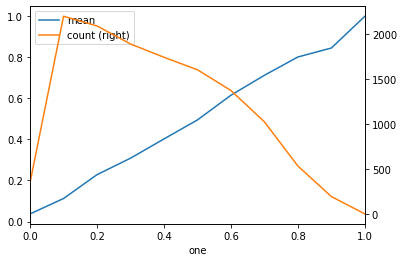

In [409]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [410]:
df_res_grouped

,mean,count
one,,
0.0,0.037037,351
0.1,0.112171,2202
0.2,0.228271,2094
0.3,0.308505,1893
0.4,0.402292,1745
0.5,0.495019,1606
0.6,0.615273,1375
0.7,0.712476,1026
0.8,0.801498,534


### Prediction

#### Categorical

In [327]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].shift(1)

In [328]:
eval_data.groupby('target').mean()

,diff_OPEN_CLOSE,diff_LOW_HIGH,chng_HIGH,chng_CLOSE,foreign_stocks_mean,chng_HIGH1_CLOSE,roll2m_chng_HIGH,same_CLOSE_HIGH,roll20m_same_CLOSE_HIGH,roll20min_diff_LOW_HIGH,...,roll20min_chng_OPEN1_CLOSE,roll3min_same_OPEN_HIGH,roll20min_chng_HIGH1_CLOSE,roll3min_move_strength,roll5max_same_CLOSE_LOW,roll2m_same_OPEN_LOW,roll3max_chng_CLOSE,roll2m_same_OPEN_HIGH,pred_class,pred_proba
target,,,,,,,,,,,,,,,,,,,,,
0.0,0.007863,0.052556,-0.063835,-0.284651,-0.444975,3.558394,-0.080671,0.218252,0.240787,0.011863,...,-9.122602,0.099228,-5.813851,-14906.076406,0.509213,0.203561,3.520182,0.340388,0.175548,0.298817
1.0,-0.000237,0.052386,0.229273,0.542844,-0.040192,2.594333,0.342434,0.249399,0.247133,0.012742,...,-10.062131,0.095028,-6.353139,-16668.291783,0.511427,0.216119,4.690038,0.325180,0.517642,0.498957


In [329]:
eval_data.groupby('pred_class').mean()

,diff_OPEN_CLOSE,diff_LOW_HIGH,chng_HIGH,chng_CLOSE,foreign_stocks_mean,chng_HIGH1_CLOSE,roll2m_chng_HIGH,same_CLOSE_HIGH,roll20m_same_CLOSE_HIGH,roll20min_diff_LOW_HIGH,...,roll20min_chng_OPEN1_CLOSE,roll3min_same_OPEN_HIGH,roll20min_chng_HIGH1_CLOSE,roll3min_move_strength,roll5max_same_CLOSE_LOW,roll2m_same_OPEN_LOW,roll3max_chng_CLOSE,roll2m_same_OPEN_HIGH,target,pred_proba
pred_class,,,,,,,,,,,,,,,,,,,,,
0.0,0.008618,0.052261,-0.193783,-0.446922,-0.727197,3.642132,0.053079,0.219207,0.243321,0.011915,...,-9.288420,0.103013,-5.931401,-15611.948129,0.511852,0.201318,3.800890,0.346201,0.266504,0.255572
1.0,-0.003966,0.053011,0.596284,1.116283,0.699053,2.164426,0.145520,0.255010,0.242986,0.012845,...,-9.921543,0.085421,-6.221848,-15511.617586,0.506012,0.224324,4.347087,0.308241,0.646794,0.646693


In [330]:
eval_data.groupby('pred_proba').mean()

,diff_OPEN_CLOSE,diff_LOW_HIGH,chng_HIGH,chng_CLOSE,foreign_stocks_mean,chng_HIGH1_CLOSE,roll2m_chng_HIGH,same_CLOSE_HIGH,roll20m_same_CLOSE_HIGH,roll20min_diff_LOW_HIGH,...,roll20min_chng_OPEN1_CLOSE,roll3min_same_OPEN_HIGH,roll20min_chng_HIGH1_CLOSE,roll3min_move_strength,roll5max_same_CLOSE_LOW,roll2m_same_OPEN_LOW,roll3max_chng_CLOSE,roll2m_same_OPEN_HIGH,target,pred_class
pred_proba,,,,,,,,,,,,,,,,,,,,,
0.0,0.020122,0.061179,-0.378769,-1.495376,-1.565979,5.066451,-0.236613,0.187625,0.228543,0.012563,...,-9.847427,0.101796,-6.136963,-21548.823236,0.514970,0.176647,3.399127,0.344311,0.049900,0.000000
0.1,0.015957,0.056992,-0.624396,-1.408928,-1.229887,4.559461,-0.134576,0.182365,0.229584,0.012505,...,-9.317050,0.092685,-5.967196,-21404.910859,0.514028,0.179860,3.338062,0.346443,0.108717,0.000000
0.2,0.010056,0.055823,-0.155948,-0.320990,-0.965411,4.401739,-0.101141,0.215325,0.237730,0.012274,...,-9.485488,0.100873,-6.024329,-17185.994935,0.498545,0.194229,3.810828,0.347478,0.225024,0.000000
0.3,0.005150,0.048559,-0.235592,-0.246348,-0.519097,3.176935,0.324833,0.232930,0.253001,0.011674,...,-9.105333,0.107379,-5.868922,-10847.021269,0.518722,0.210628,4.864693,0.350220,0.313877,0.000000
0.4,0.002513,0.046796,0.186794,0.173305,-0.234490,2.391453,0.203214,0.251136,0.253665,0.011301,...,-8.931119,0.110795,-5.693940,-6343.009819,0.501705,0.221591,3.442877,0.340057,0.400568,0.000000
0.5,0.000714,0.047820,0.227016,0.404505,0.099858,2.407255,0.123309,0.239218,0.255262,0.011481,...,-9.607729,0.099482,-6.137347,-16311.107349,0.526740,0.217941,3.611292,0.342151,0.503738,0.486486
0.6,-0.001611,0.047639,0.569210,0.828287,0.428890,1.936923,0.295307,0.245351,0.249714,0.011980,...,-9.264212,0.092275,-5.913810,-28277.173103,0.487124,0.223534,3.777319,0.311516,0.608727,1.000000
0.7,-0.004404,0.052370,0.643633,1.212481,0.745995,2.031858,0.236521,0.273092,0.253865,0.012596,...,-10.078842,0.086345,-6.430606,-10722.131476,0.538153,0.246988,4.769907,0.306727,0.689759,1.000000
0.8,-0.008564,0.065255,0.840456,2.070174,1.591249,2.510478,-0.187532,0.261426,0.204113,0.015958,...,-11.079028,0.065814,-6.514822,-6940.298905,0.473492,0.202925,5.242275,0.279707,0.773309,1.000000


#### Prediction for couple of papers

In [331]:
# res_cols = ['DTYYYYMMDD','TICKER', 'OPEN', 'LOW', 'HIGH','CLOSE', 'target_OPEN_chng',
#             'target_HIGH_chng', 'target_CLOSE_chng', 'prob_newHIGH']

# res = pd.DataFrame(columns=res_cols)

In [379]:
res = pd.DataFrame()

In [380]:
for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
    df = transform_one_paper_ch(df)
    
    df = df.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

    df.loc[:,'pred_class'] = model.predict(df[train_cols])
    df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]
    
    df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
    df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
    df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:,['DTYYYYMMDD','TICKER','OPEN','LOW','HIGH', 'CLOSE', 
                                      'target', 'pred_class', 'target_OPEN_chng',
                                      'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']].tail(1)
    res = pd.concat([res, one_res])
#     res = pd.concat([res, pd.DataFrame([[one_res.DTYYYYMMDD.values[0], 
#                                    one_res.TICKER.values[0],
#                                    one_res.OPEN.values[0],
#                                    one_res.LOW.values[0],
#                                    one_res.HIGH.values[0],
#                                    one_res.CLOSE.values[0],
#                                    one_res.target_OPEN_chng.values[0],
#                                    one_res.target_HIGH_chng.values[0],
#                                    one_res.target_CLOSE_chng.values[0],
#                                    one_res.pred_prob.values[0]]], columns=res_cols)])

100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


In [387]:
res.sort_values('pred_prob', ascending=False).drop(['pred_class','target_OPEN_chng', 'target'], axis = 1).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target_HIGH_chng,target_CLOSE_chng,pred_prob
3734,2020-04-09,AMREST,22.500,22.500,24.850,24.8500,NaN,NaN,0.895604
814,2020-04-09,WIG-ODZIEZ,3130.450,3113.360,3277.720,3277.7200,NaN,NaN,0.893288
4663,2020-04-09,LPP,5370.000,5305.000,5635.000,5635.0000,NaN,NaN,0.874304
1679,2020-04-09,SUNEX,8.020,7.940,8.600,8.6000,NaN,NaN,0.859708
3569,2020-04-09,WIG20LEV,290.330,284.190,298.720,297.1300,NaN,NaN,0.857508
2886,2020-04-09,WIG-CHEMIA,6821.440,6760.640,7077.220,7069.3400,NaN,NaN,0.855607
429,2020-04-09,MLSYSTEM,24.400,23.900,24.800,24.8000,NaN,NaN,0.847941
1230,2020-04-09,WIRTUALNA,58.000,58.000,64.000,64.0000,NaN,NaN,0.844854
3636,2020-04-09,PGNIG,3.550,3.482,3.628,3.6200,NaN,NaN,0.842153
2945,2020-04-09,GRUPAAZOTY,24.800,24.500,25.600,25.5000,NaN,NaN,0.839832


In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

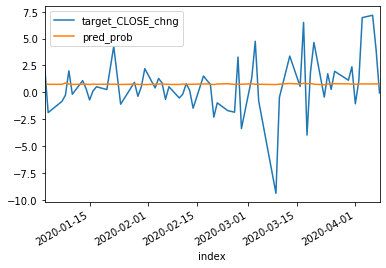

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

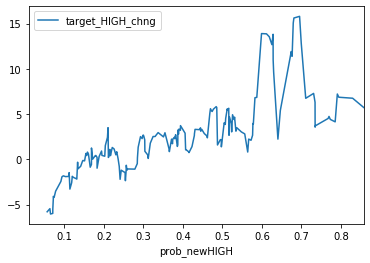

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

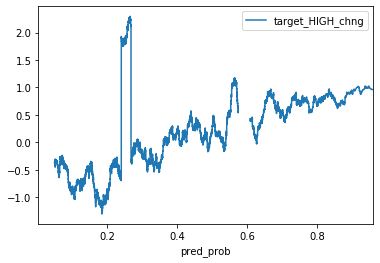

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


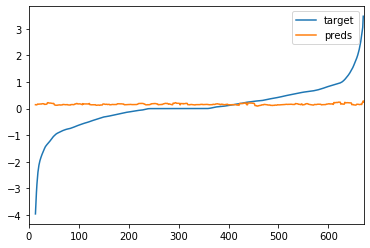

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

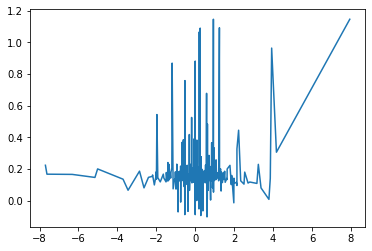

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

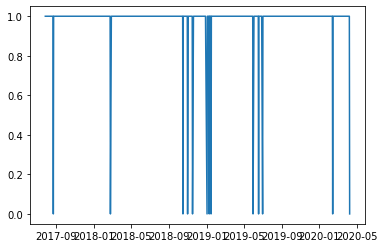

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
